In [20]:
!pip install -r requirements.txt

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached community-1.0.0b1-py3-none-any.whl
  Using cached pyogrio-0.10.0-cp310-cp310-win_amd64.whl.metadata (5.6 kB)
  Using cached pyproj-3.7.0-cp310-cp310-win_amd64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp310-cp310-win_amd64.whl.metadata (7.2 kB)
  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp310-cp310-win_amd64.whl (16.2 MB)
Using cached pyproj-3.7.0-cp310-cp310-win_amd64.whl (6.2 MB)
Using cached shapely-2.0.6-cp310-cp310-win_amd64.whl (1.4 MB)
Using cached flask-3.1.0-py3-none-any.whl (102 kB)
Using cached blinker-1.9.0-py3-none-a

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
#from Funciones.GEO_LIB import Plot, Poligono, Distancia, Geodecodificacion
from tqdm import tqdm
from scipy import stats
import numpy as np
import community as community_louvain
import networkx as nx
from itertools import count
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

In [3]:
# consolidado_reviews_Los_Rios.xlsx: Set de datos originales
df_base = pd.read_excel('data/consolidado_reviews_Los_Rios.xlsx')
# consolidado_reviews_Los_Rios_con_latlon.xlsx: Set de datos con latitud y longitud pero con otros campos filtrados ('N', 'place_id', 'Latitud', 'Longitud', 'name', 'id_usuario', 'stars', 'fecha')
df_latlon = pd.read_excel('data/consolidado_reviews_Los_Rios_con_latlon.xlsx')
# nodos_Los_Rios.xlsx: Set de datos sólo con nodos con el "stars" promediado.
df_nodos = pd.read_excel('data/nodos_Los_Rios.xlsx')


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Cargar el dataset
ruta_archivo = 'ruta_al_archivo.csv'  # Cambia esto por la ruta de tu archivo
datos = pd.read_excel('data/consolidado_reviews_Los_Rios_con_latlon.xlsx')

# Filtrar y limpiar datos
datos = datos.dropna(subset=['id_usuario', 'place_id'])  # Eliminar filas con valores faltantes
datos = datos[['id_usuario', 'place_id']].drop_duplicates()  # Eliminar duplicados

# Crear grafo bipartito
B = nx.Graph()

# Añadir nodos de los dos conjuntos
usuarios = datos['id_usuario'].unique()
lugares = datos['place_id'].unique()

B.add_nodes_from(usuarios, bipartite=0)  # Conjunto de usuarios
B.add_nodes_from(lugares, bipartite=1)  # Conjunto de lugares

# Añadir aristas (usuario -> lugar)
aristas = list(zip(datos['id_usuario'], datos['place_id']))
B.add_edges_from(aristas)

# Análisis básico de la red
print(f"Número de nodos: {B.number_of_nodes()}")
print(f"Número de aristas: {B.number_of_edges()}")

# Visualización de la red bipartita
pos = nx.spring_layout(B)  # Layout para el grafo
plt.figure(figsize=(12, 12))
nx.draw(B, pos, with_labels=False, node_size=10, alpha=0.7)
plt.title("Red Bipartita de Usuarios y Lugares")
plt.show()

# Opcional: Proyección unimodal (por ejemplo, red de lugares)
lugares_proyeccion = nx.bipartite.weighted_projected_graph(B, lugares)

# Análisis de la proyección
print(f"Red proyectada (lugares): {lugares_proyeccion.number_of_nodes()} nodos, {lugares_proyeccion.number_of_edges()} aristas")


In [4]:
print(df_latlon.columns)

Index(['N', 'place_id', 'Latitud', 'Longitud', 'name', 'id_usuario', 'stars',
       'fecha'],
      dtype='object')


In [6]:
usuarios = df_latlon.groupby('id_usuario').agg(count=('place_id','count')).reset_index()
usuarioslista = list(usuarios['id_usuario'][usuarios['count']>1])
red_datos =df_latlon[df_latlon['id_usuario'].isin(usuarioslista)]  

In [7]:
# Se considerará pa la información del id del usduario y del lugar
red_datos =red_datos[['id_usuario','place_id']]
#Todas las combinaciones del cliente (primera columna) y las distintas combinaciones de lugares i y j
red_datos = red_datos.merge(red_datos, on='id_usuario', how='outer')
red_datos.columns = [0,'i', 'j'] 
df_agg = red_datos.groupby(['i', 'j']).agg(pairs =('j','count')) # recordar que están duplicados



#Generamos la lista de nodos para diferenciar cada lugar, Con esto obtenemos un ID distintivo para cada lugar
nodes = pd.concat([df_agg.reset_index()['i'], df_agg.reset_index()['j']]).drop_duplicates().sort_values()\
        .to_frame('lugar').reset_index(drop=True).reset_index().rename(columns={'index' : 'id'})


# Lista de Coocurrencia
# Pasamos a trabajar sobre los IDs generados en el punto anterior
list_cooc = (df_agg.reset_index().merge(nodes[['lugar','id']], left_on='i', right_on='lugar')
            .drop(columns=['i', 'lugar']).rename(columns={'id' : 'i'})
            .merge(nodes[['lugar', 'id']], left_on='j', right_on='lugar')
            .drop(columns=['j', 'lugar']).rename(columns={'id' : 'j'})
            [['i', 'j', 'pairs']].sort_values(['i', 'j']))

# Se filtran todos los pesos con valor 0
list_cooc_2 = list_cooc[list_cooc['pairs']>0]

In [11]:
# Se crea una red bipartita con pesos en los enlaces
W = nx.Graph()

for i in range(len(list_cooc_2)):
    W.add_edge(list_cooc_2['i'].iloc[i], list_cooc_2['j'].iloc[i], weight=list_cooc_2['pairs'].iloc[i])
    

In [12]:
dict10=dict(W.degree())  # node 0 has degree 1
sorted_dict0 = {}
sorted_keys0 = sorted(dict10, key=dict10.get)  # [1, 3, 2]

for w in sorted_keys0:
    sorted_dict0[w] = dict10[w]
# sorted_dict0


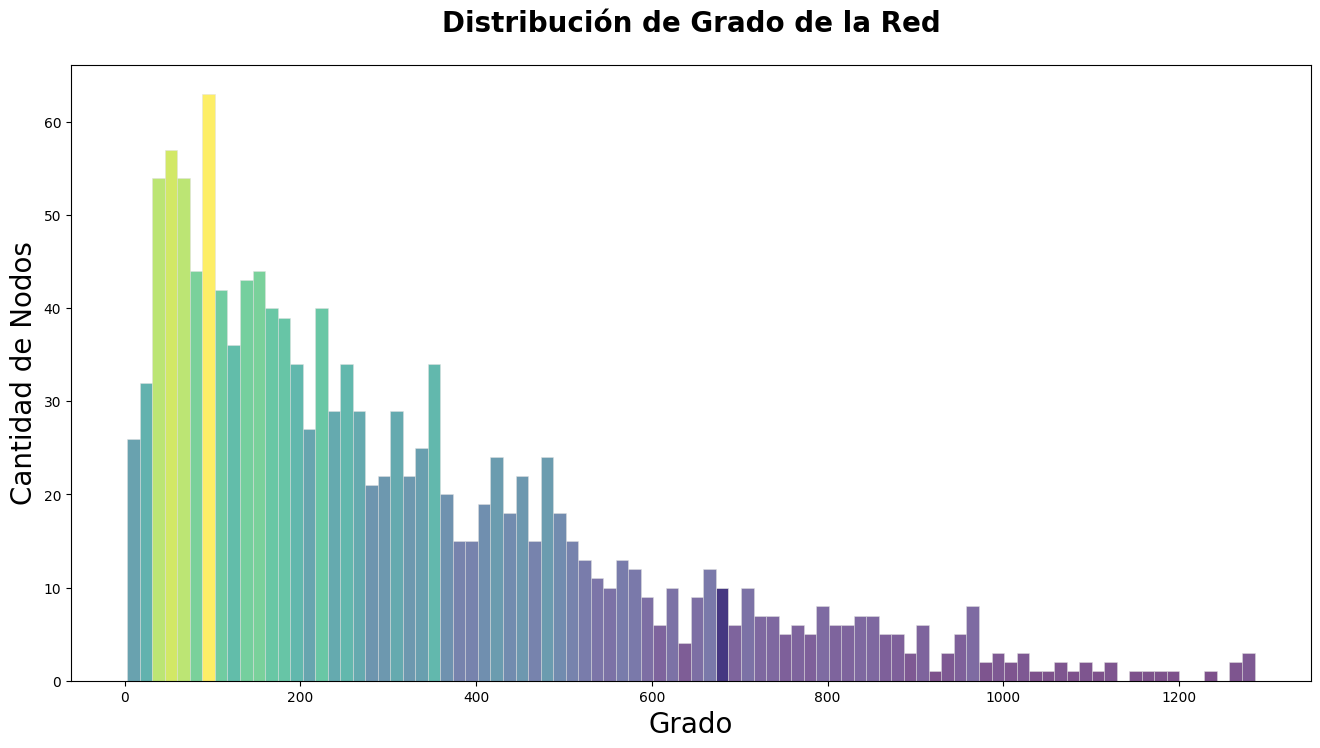

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

values = list(sorted_dict0.values())
n, bins, patches = plt.hist(values, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
# Make one bin stand out   
patches[47].set_alpha(1) # Set opacity
# Add title and labels with custom font sizes
plt.title('Distribución de grado de la Red', fontsize=12)
plt.xlabel('Grado', fontsize=20)
plt.ylabel('Cantidad de Nodos', fontsize=20)
ax.set_title("Distribución de Grado de la Red",
             pad=24, fontweight=700, fontsize=20)
plt.show()

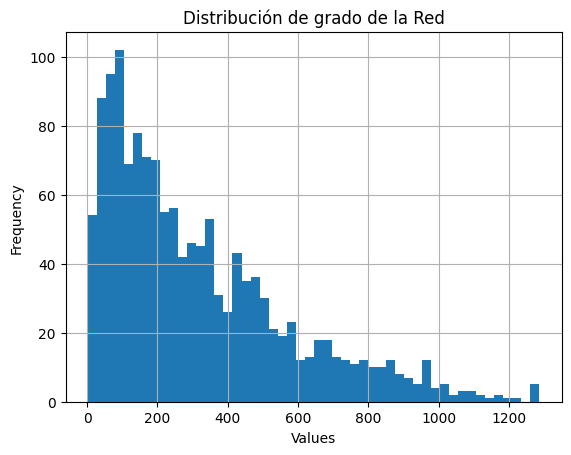

In [15]:
# Get the values from the dictionary
values = list(dict10.values())

# Create the histogram
plt.hist(values, bins=50)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribución de grado de la Red')

# Add grid
plt.grid(True)

# Show the histogram
plt.show()

Número de nodos:  1390
Número de enlaces:  218530
-------
Grado promedio:  314.431654676259
-------
Grado mínimo:  3
Grado máximo:  1286
-------
Densidad:  0.22637268155238227
Diametro:  3


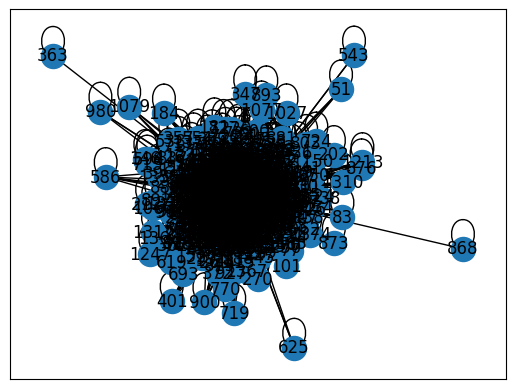

In [16]:
#F0.edges(data=True)
N10 = len(W)
L10 = W.size()
degrees10 = list(dict(W.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(W))
print('Diametro: ',nx.diameter(W))

nx.draw_networkx(W)

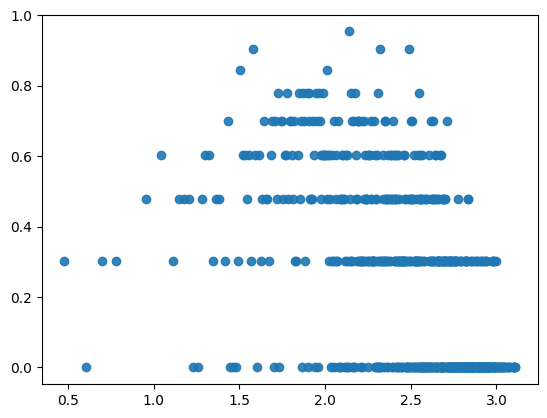

In [17]:
import numpy as np
d = {}
for i, j in dict(nx.degree(W)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

 26%|██▌       | 362/1390 [00:29<01:31, 11.21it/s]C:\Users\GabAl\AppData\Local\Temp\ipykernel_2684\2612152327.py:38: RuntimeWarning: invalid value encountered in sqrt
  p1 = np.sqrt(max(M[i],M[j])-2)
100%|██████████| 1390/1390 [01:50<00:00, 12.53it/s]
C:\Users\GabAl\AppData\Local\Temp\ipykernel_2684\2612152327.py:52: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_edgelist_phi  = pd.DataFrame(phi, index=indices, columns=columns).stack().reset_index()
C:\Users\GabAl\AppData\Local\Temp\ipykernel_2684\2612152327.py:56: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_edge

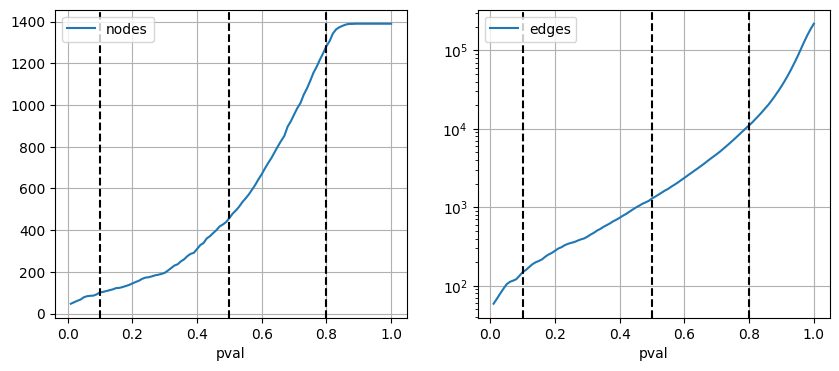

In [22]:
# Matriz de Co-Ocurrencia
od_matrix = list_cooc.set_index(['i', 'j']).unstack().fillna(0)
indices = od_matrix.index
columns = od_matrix.columns
od_matrix = od_matrix.values

# eliminamos la diagonal (decisión de análisis: no nos interesan los auto-enlaces)
od_matrix = od_matrix-np.diag(od_matrix.diagonal())


n = len(od_matrix)
phi = np.zeros((n,n)) #matrix to store the phi correlations
tval = np.zeros((n,n))
pval = np.zeros((n,n)) # Significancia
phi2 = np.zeros((n,n)) # Pesos finales
exit = np.zeros((n,n)) # Matriz con unos



M = od_matrix.sum(axis=1) # total number of obervations of each JUEGO (suma sobre las filas)
T = sum(M) # Total number of observations

pval_limit = 1 # significancia limite, 1 significa no filtrar
cnt_limit = 0 # minimo numero de coincidencias a considerar en la od_matrix, 0 significa no filtrar


# El mitico doble for
for i in tqdm(range(n)):# https://github.com/tqdm/tqdm  (barra de progreso)
    for j in range(n):
        p1 = T*od_matrix[i,j]-M[i]*M[j]
        p2 = np.sqrt(M[i]*M[j]*(T-M[i])*(T-M[j]))
        if p2 == 0:
            phi[i,j] = 0
        else:
            phi[i,j] = p1/p2
            
        if True: #phi[i,j] > 0:
            p1 = np.sqrt(max(M[i],M[j])-2)
            p2 = np.sqrt(1-phi[i,j]**2)
            tval[i,j] = phi[i,j]*p1/p2
            pval[i,j] = stats.t.sf(np.abs(tval[i,j]),max(M[i],M[j])-2)*2
            # Se evaluan los criterios para ver si la correlacion es significativa
            if pval[i,j] <= pval_limit and od_matrix[i,j] > cnt_limit:
                exit[i,j] = 1
                phi2[i,j] = phi[i,j]
            else:
                exit[i,j] = 0
                phi2[i,j] = 0

# Creamos un dataframe con toda la inforamcion estadistica de la red

df_edgelist_phi  = pd.DataFrame(phi, index=indices, columns=columns).stack().reset_index()
df_edgelist_phi.columns = ['source', 'target', 'phi']# esto es por convención, recuerden que es este grafo es no-dirigido
df_edgelist_phi = df_edgelist_phi[df_edgelist_phi['source']<=df_edgelist_phi['target']] # eliminamos duplicados

df_edgelist_pval = pd.DataFrame(pval, index=indices, columns=columns).stack().reset_index()
df_edgelist_pval.columns = ['source', 'target', 'pval']
df_edgelist_pval = df_edgelist_pval[df_edgelist_pval['source']<=df_edgelist_pval['target']] # eliminamos duplicados


# El DataFrame final contiene el valor phi, el pval y el número de veces que ocurre que dos IDs i y j están conectados
df = df_edgelist_phi.merge(df_edgelist_pval).merge(list_cooc.rename(columns={'i': 'source', 'j': 'target'}), how='left')
df['pairs'] = df['pairs'].fillna(0).astype(int) 
df = df[df['pairs']>0]

# Visualización del número de nodos y aristas según un filtro en pval
pvalues = np.arange(0.01,1.01,0.01)#Return evenly spaced values within a given interval.
total_nodes = []
total_edges = []
for p in pvalues:
    __df = df.pipe(lambda x : x[x['pval']<=p])
    n_nodes = pd.concat([__df['source'], __df['target']]).nunique()
    total_nodes.append(n_nodes)
    total_edges.append(len(__df))
pval_df = pd.DataFrame([pvalues, total_nodes, total_edges]).T
pval_df.columns = ['pval', 'nodes', 'edges']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
pval_df.plot('pval', 'nodes', ax=ax1)
pval_df.plot('pval', 'edges', ax=ax2)
for pval in [0.1, 0.5, 0.8]:
    ax1.axvline(pval, ls='--', color='k')
    ax2.axvline(pval, ls='--', color='k')

ax2.set_yscale('log')
ax1.grid()
ax2.grid()

In [23]:
# Filtros
pval_filt=0.1
df_viz=df[df['pval']<=pval_filt]
df_viz=df_viz[df_viz['source']!=df_viz['target']]
df_viz

,source,target,phi,pval,pairs
7309,5,374,0.006667,8.957773e-02,255
7317,5,382,0.008212,3.652153e-02,518
7319,5,384,0.006486,9.864227e-02,920
7411,5,476,0.019479,7.032491e-07,2698
7721,5,786,0.014049,3.467742e-04,802
...,...,...,...,...,...
935572,1140,1348,0.019997,8.834857e-05,1041
938309,1152,1163,0.017495,2.213358e-02,91
940890,1163,1192,0.014731,5.402828e-02,115
940943,1163,1245,0.017558,2.165531e-02,146


In [24]:
# Creación de la red
G=nx.from_pandas_edgelist(df_viz, 'source', 'target')

# The network has disconnected components, let's check the size of each component in descending order
compon=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Non connected: 16
Connected nodes en la compoenente gigante: 85 de 101 nodos totales.
[85, 6, 4, 2, 2, 2]


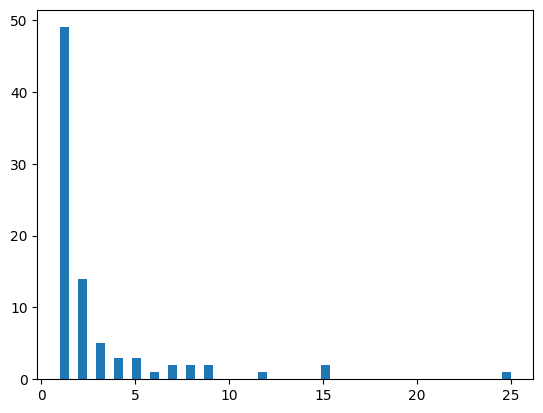

In [25]:
# Filtered
F = S[0]
dict1=dict(F.degree())  # node 0 has degree 1
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
plt.hist((dict1.values()), bins=50)
plt.show()

Número de nodos:  85
Número de enlaces:  120
-------
Grado promedio:  2.823529411764706
-------
Grado mínimo:  1
Grado máximo:  25
-------
Densidad:  0.03361344537815126
Diametro:  8


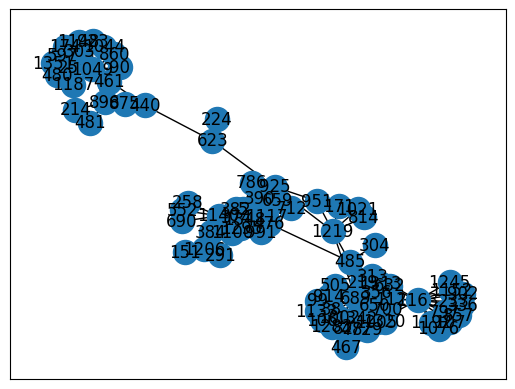

In [26]:
N10 = len(F)
L10 = F.size()
degrees10 = list(dict(F.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(F))
print('Diametro: ',nx.diameter(F))

nx.draw_networkx(F)

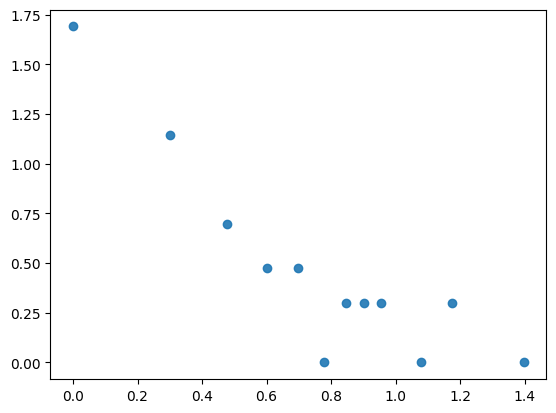

In [27]:
d = {}
for i, j in dict(nx.degree(F)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

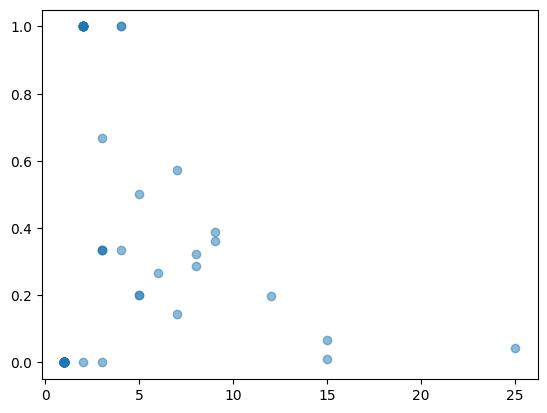

In [28]:
degree_g = dict(nx.degree(F))
clustering_g=dict(nx.clustering(F))

x = degree_g.values()
y = clustering_g.values()


# colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()

In [31]:
import community.community_louvain as cl
from community import community_louvain
# compute the best partition
partition = community_louvain.best_partition(F, random_state=5)
A = F

partition_df = pd.DataFrame([partition]).T.reset_index()
partition_df.columns = ['id', 'partition']
partition_df.groupby('partition')['id'].count()

partition
0    20
1    11
2    19
3    13
4    22
Name: id, dtype: int64

Se detectan 5 comunidades


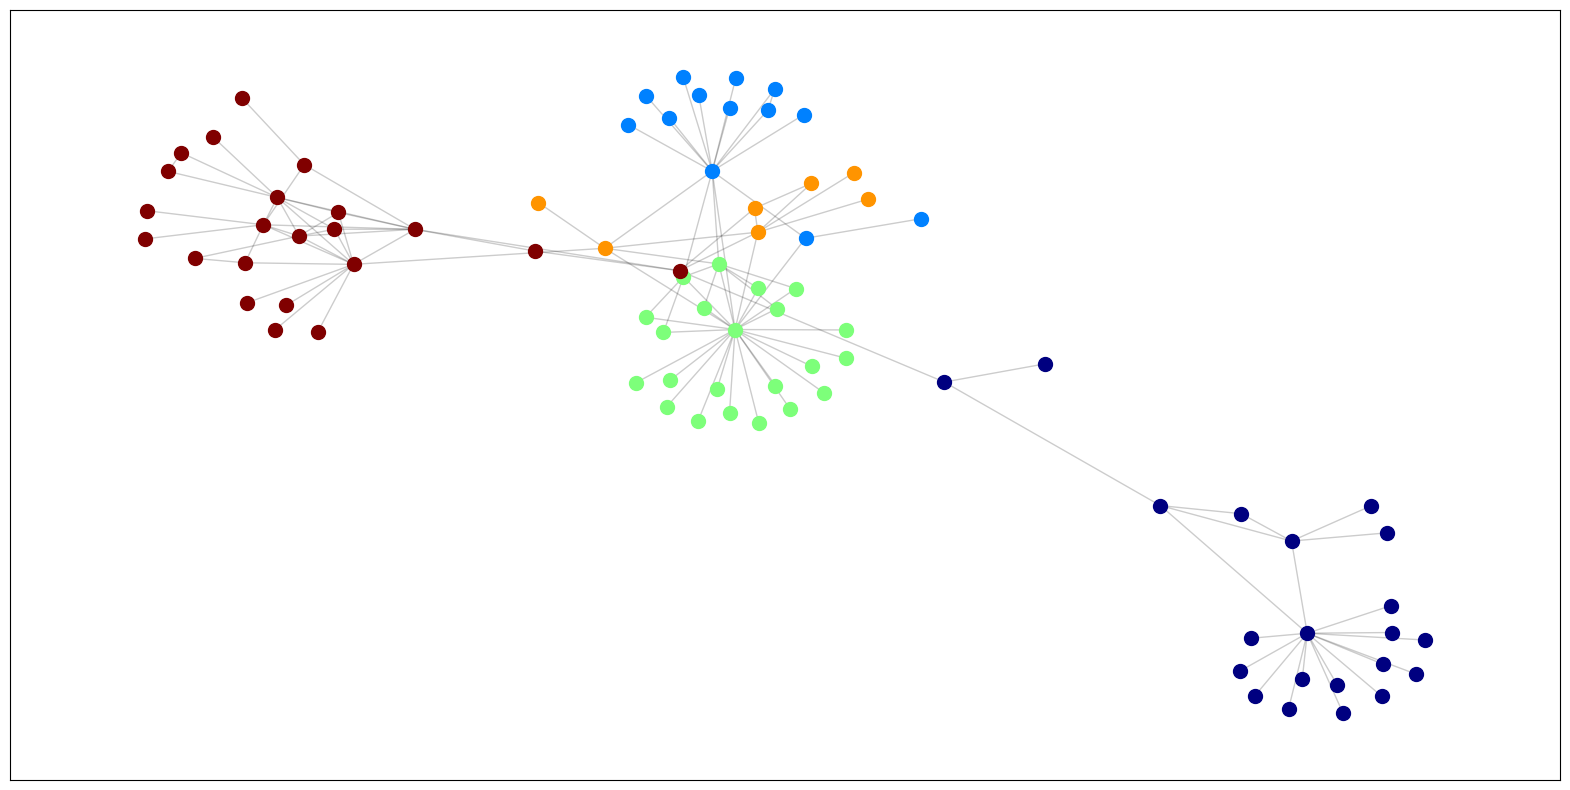

In [32]:
plt.figure(figsize=(20, 10))
#https://datoslab.cl/hes/

partition = community_louvain.best_partition(A)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))

pos = nx.spring_layout(A) # Layout para la red (coordenadas de los nodos y enlaces)

count = 0
colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(A, pos, list_nodes, node_size = 100, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores
nx.draw_networkx_edges(A, pos, alpha=0.2)#plotea enlaces
plt.show()